In [1]:
import os
import torch
import pandas as pd
from polymerlearn.utils import get_IV_add, GraphDataset

# Load data from local path:
data = pd.read_csv(os.path.join('/Users/owenqueen/Desktop/eastman_project-confidential/Eastman_Project/CombinedData', 
            'pub_data.csv'))

add = get_IV_add(data)

dataset = GraphDataset(
    data = data,
    structure_dir = '../Structures/AG/xyz',
    Y_target=['IV'],
    test_size = 0.2,
    add_features=add
)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now we'll instantiate our model, using the standard IV model that gets the best prediction scores.

In [2]:
from polymerlearn.models.gnn import PolymerGNN_IV_evidential
from polymerlearn.utils import CV_eval_evidential

model_generator_kwargs = {
    'input_feat': 6,         # How many input features on each node; don't change this
    'hidden_channels': 32,   # How many intermediate dimensions to use in model
                            # Can change this ^^
    'num_additional': 4      # How many additional resin properties to include in the prediction
                            # Corresponds to the number in get_IV_add
}

optimizer_gen = torch.optim.AdamW
criterion = torch.nn.MSELoss()

all_predictions, all_y, all_inds = CV_eval_evidential(
    dataset = dataset,
    model_generator = PolymerGNN_IV_evidential,
    optimizer_generator = optimizer_gen,
    model_generator_kwargs = model_generator_kwargs,
    optimizer_kwargs = {'lr': 0.0001, 'weight_decay':0.01},
    epochs = 1000,
    batch_size = 64,
    verbose = 1,
    use_val = False,
    val_size = 0.05,
    early_stop_delay=100
)

/Users/owenqueen/Desktop/Eastman_project-Confidential/Eastman_Project/PolymerGNN/polymerlearn/utils/graph_prep.py:425: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  return self.test_data, torch.tensor(self.Ytest).float(), self.add_test, test_inds


Fold: 1 	 Epoch: 0,                     	 Train r2: -2.5598 	 Train Loss: 136.8438
Fold: 1 	 Epoch: 50,                     	 Train r2: 0.5151 	 Train Loss: -32.7507
Fold: 1 	 Epoch: 100,                     	 Train r2: 0.6556 	 Train Loss: -44.7641
Fold: 1 	 Epoch: 150,                     	 Train r2: 0.6834 	 Train Loss: -47.3659
Fold: 1 	 Epoch: 200,                     	 Train r2: 0.6650 	 Train Loss: -70.6051
Fold: 1 	 Epoch: 250,                     	 Train r2: 0.7222 	 Train Loss: -65.3493
Fold: 1 	 Epoch: 300,                     	 Train r2: 0.6703 	 Train Loss: -75.3250
Fold: 1 	 Epoch: 350,                     	 Train r2: 0.8412 	 Train Loss: -87.5964
Fold: 1 	 Epoch: 400,                     	 Train r2: 0.5841 	 Train Loss: -51.0292
Fold: 1 	 Epoch: 450,                     	 Train r2: 0.8660 	 Train Loss: -103.5420
Fold: 1 	 Epoch: 500,                     	 Train r2: 0.8167 	 Train Loss: -86.0289
Fold: 1 	 Epoch: 550,                     	 Train r2: 0.8673 	 Train Loss: -9

In [41]:
# Examine uncertainties:
from polymerlearn.utils.uncertainty import epistemic

# def aleatoric(outdict):
#     '''
#     Aleatoric uncertainty given the output of evidential model
#     '''
#     beta = outdict['beta']
#     alpha = outdict['alpha']

#     return (beta / (alpha - 1)).item()

# Screen all epistemic and aleatoric uncertanties:
pred_uncertain = {}
uncertain = []
uncertain_a = []
for i in range(len(all_predictions)):
    ind = all_inds[i]
    pred_uncertain[ind] = epistemic(all_predictions[i]).item()
    uncertain.append(epistemic(all_predictions[i]).item())
    uncertain_a.append(aleatoric(all_predictions[i]))

In [45]:
# Find most uncertain predictions:
import numpy as np

trim_data = data[data['IV'].notna()]
absolute_errors = [np.abs(all_predictions[i]['gamma'].item() - all_y[i]) for i in range(len(all_y))]

largest = np.argsort(uncertain)

Lar = trim_data.iloc[[all_inds[i] for i in largest],:]

Lar['uncertainty'] = [uncertain[i] for i in largest]
Lar['abs_error'] = [absolute_errors[i] for i in largest]

print(Lar)

Lar.to_csv('uncertainty_estimates_IV.csv')

       Resin#  Reactor Reaction Solvent     AN        OHN OHN (primary)  \
124       144      Rig             Neat  17.15  25.404422           NaN   
120       140      Rig             Neat  20.65  18.542329           NaN   
115       135      Rig             Neat  22.66  22.410140           NaN   
155       175      Rig             Neat  24.34  32.939359           NaN   
130       150      Rig             Neat  27.37  25.455449           NaN   
..        ...      ...              ...    ...        ...           ...   
222  Resin 6b      Rig             Neat   3.80  17.600000           NaN   
99        103  Kettle            A150ND   0.90  39.000000            39   
246       C14      NaN              NaN    NaN        NaN           NaN   
212  Resin 3d      Rig             Neat   3.80  15.300000           NaN   
224  Resin 6d      Rig             Neat   2.50  16.820000           NaN   

    OHN (secondary)     IV  IV - Intrinsic     Tg  ...  %1,4-CHDM  %1,3-CHDM  \
124             NaN

<ipython-input-45-1107b8337117>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lar['uncertainty'] = [uncertain[i] for i in largest]
<ipython-input-45-1107b8337117>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lar['abs_error'] = [absolute_errors[i] for i in largest]


In [28]:
# Test MAE of all samples:
absolute_errors = [np.abs(all_predictions[i]['gamma'].item() - all_y[i]) for i in range(len(all_y))]
mae = np.mean(absolute_errors)
print('MAE before', mae)

# Remove those with uncertanties > 200:
over200_mask = [i for i in range(len(all_y)) if (uncertain[i] < 200)]
mae_adj = np.mean([np.abs(all_predictions[i]['gamma'].item() - all_y[i]) for i in over200_mask])
print('ADJ MAE', mae_adj)

pred_mask = [all_predictions[i]['gamma'].item() for i in over200_mask]
ymask = [all_y[i] for i in over200_mask]

all_pred = [all_predictions[i]['gamma'].item() for i in range(len(all_y))]

from sklearn.metrics import r2_score
print('Mask r2', r2_score(ymask, pred_mask))
print('Non-mask r2', r2_score(all_y, all_pred))

MAE before 0.06415560470564376
ADJ MAE 0.060341747381306925
Mask r2 0.7276545697460228
Non-mask r2 0.7199654555966408


In [57]:
#Break into 5 segments:
segment_len = int(len(all_pred) / 5)

r2_raw = []
r2_mask = []

for i in range(5):
    Yi = all_y[(segment_len * i) : (segment_len * (i + 1))]
    Ypredi = all_pred[(segment_len * i) : (segment_len * (i + 1))]
    pdict = all_predictions[(segment_len * i) : (segment_len * (i + 1))]

    over200_mask = [j for j in range(segment_len) \
        if (uncertain[(segment_len * i) + j] < 200)]

    pred_mask = [pdict[j]['gamma'].item() for j in over200_mask]
    ymask = [Yi[j] for j in over200_mask]    

    print(r2_score(Yi, Ypredi))

    r2_raw.append(r2_score(Yi, Ypredi))

    print(r2_score(ymask, pred_mask))

    r2_mask.append(r2_score(ymask, pred_mask))

print('Avg raw', np.mean(r2_raw))
print('Avg mask', np.mean(r2_mask))

0.7715857651252361
0.7715857651252361
0.5653589343083764
0.5653589343083764
0.7190734712416613
0.7190734712416613
0.735161661035542
0.7775550543228495
0.8818930200112174
0.8795581783132533
Avg raw 0.7346145703444067
Avg mask 0.7426262806622754


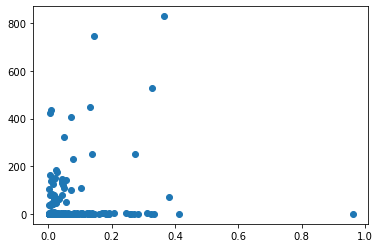

-1314219.063210123

In [44]:
import matplotlib.pyplot as plt

# Show correlation between uncertainty and error:
np.array(uncertain_a)
plt.scatter(absolute_errors, np.array(uncertain))
plt.show()

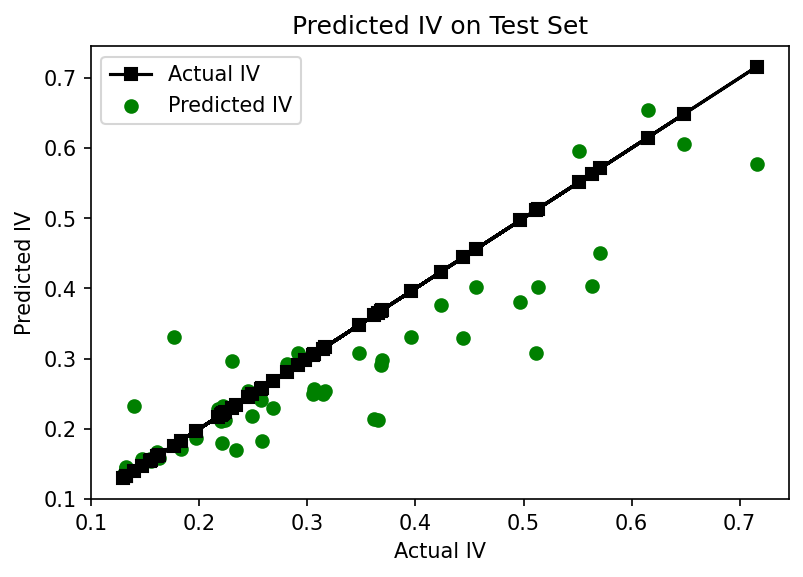

In [12]:
import matplotlib.pyplot as plt

Y = Ytest.tolist()

plt.figure(dpi=150)
plt.plot(Y, Y, marker = 's', c = 'black', label = 'Actual IV')
plt.scatter(Y, predictions, c = 'green', label = 'Predicted IV')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predicted IV on Test Set')
plt.legend()
plt.show()